# Preprocessing

In [40]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader

from torchvision.datasets import *
from torchvision.transforms import *
import matplotlib.pyplot as plt


no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

In [41]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

In [42]:

class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8),bias=False),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel,bias=False),
                nn.ReLU(inplace=True),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [43]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
test_batch = 1
#Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

#Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch, shuffle=False)

Create NN model

In [44]:
class ToyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.Conv = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=8, kernel_size=1, stride=1,padding= 0, bias=False),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=8, out_channels=8, kernel_size=1, stride=1,padding= 0, bias=False),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=3,padding= 1, bias=False,groups=8),
      nn.ReLU(inplace=True),
      SELayer(8),
      nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1, stride=1,padding= 0, bias=False),
      nn.ReLU(inplace=True),
    )  
    self.backbone = nn.Sequential(
      nn.Linear(10*10, 120, bias=False),
      nn.ReLU(),
      nn.Linear(120, 84, bias=False),
      nn.ReLU(),
      nn.Linear(84, 10, bias=False)
    )

  def forward(self, x):
    x=self.Conv(x)
    x = x.view(-1, 10*10) #transform 28*28 figure to 784 vector
    x = self.backbone(x)
    return x

FP32_model = ToyModel()
print(FP32_model)

ToyModel(
  (Conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), groups=8, bias=False)
    (5): ReLU(inplace=True)
    (6): SELayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=8, bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (7): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (8): ReLU(inplace=True)
  )
  (backbone): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=False)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=False)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=False)
  )
)


In [45]:
#train model
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  #Set the model to train mode
  model.train()
  for batch, (x, y) in enumerate(dataloader):
    if use_gpu:
      x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    #forward
    pred = model(x)

    #loss
    loss = loss_fn(pred, y)

    #backward
    loss.backward()

    #optimize
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
  #set model to evaluate mode
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in dataloader:
      if use_gpu:
        x, y = x.cuda(), y.cuda()
      pred = model(x)
      test_loss = loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item() #calculate accuracy
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [46]:
learning_rate = 1e-3
epochs = 3
loss_fn = nn.CrossEntropyLoss() #define loss function
optimizer = torch.optim.Adam(FP32_model.parameters(), lr=learning_rate)  #define optimizer

FP32_model.to(device) #let model on GPU

ToyModel(
  (Conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), groups=8, bias=False)
    (5): ReLU(inplace=True)
    (6): SELayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=8, bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (7): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (8): ReLU(inplace=True)
  )
  (backbone): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=False)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=False)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=False)
  )
)

In [47]:
#Training
for i in range(epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train_loop(train_loader, FP32_model, loss_fn, optimizer)
  test_loop(test_loader, FP32_model, loss_fn)

Epoch 1
-------------------------------
loss: 2.302585  [   32/60000]
loss: 2.294250  [ 3232/60000]
loss: 1.526727  [ 6432/60000]
loss: 0.785593  [ 9632/60000]
loss: 1.007656  [12832/60000]
loss: 0.653374  [16032/60000]
loss: 0.682098  [19232/60000]
loss: 0.753057  [22432/60000]
loss: 0.494787  [25632/60000]
loss: 0.730136  [28832/60000]
loss: 0.489663  [32032/60000]
loss: 0.573711  [35232/60000]
loss: 0.593057  [38432/60000]
loss: 0.403741  [41632/60000]
loss: 0.426896  [44832/60000]
loss: 0.579764  [48032/60000]
loss: 0.581057  [51232/60000]
loss: 0.508279  [54432/60000]
loss: 0.855842  [57632/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.000126 

Epoch 2
-------------------------------
loss: 0.432545  [   32/60000]
loss: 0.360006  [ 3232/60000]
loss: 0.481926  [ 6432/60000]
loss: 0.569693  [ 9632/60000]
loss: 0.882042  [12832/60000]
loss: 0.636134  [16032/60000]
loss: 0.671663  [19232/60000]
loss: 0.573292  [22432/60000]
loss: 0.465550  [25632/60000]
loss: 0.407123  [28832/60000

# Quantization definition

####Question 1.####

Use
>$S=(r_{\mathrm{max}} - r_{\mathrm{min}}) / (q_{\mathrm{max}} - q_{\mathrm{min}})$

>$Z = q_{\mathrm{min}} - r_{\mathrm{min}} / S$

to calculate scale factor and zero point of a tensor


In [48]:
def get_scale_and_zero_point(fp32_tensor, bitwidth=8):
  q_min, q_max = -(2**(bitwidth-1)), 2**(bitwidth-1) - 1
  fp_min = fp32_tensor.min().item()
  fp_max = fp32_tensor.max().item()
  
  #####################################################

  scale = (fp_max-fp_min) / (q_max-q_min)
  zero_point = q_min-fp_min /scale

  #####################################################


  zero_point = round(zero_point)          #round
  zero_point = max(q_min, min(zero_point, q_max)) #clip

  return scale, int(zero_point)

####Question 2.####

Use $q=r/S + Z$ to quantize a tensor

In [49]:
def linear_quantize(fp32_tensor, bitwidth=8):
  q_min, q_max = -(2**(bitwidth-1)), 2**(bitwidth-1) - 1

  scale, zero_point = get_scale_and_zero_point(fp32_tensor)

  #####################################################

  q_tensor = torch.round( fp32_tensor/scale ) +zero_point

  #####################################################

  #clamp
  q_tensor = torch.clamp(q_tensor, q_min, q_max)
  return q_tensor, scale, zero_point  

####Question 3.####

Use
> $q_{\mathrm{output}} = M * \mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Z_{\mathrm{output}}$

> $M = S_{\mathrm{input}} * S_{\mathrm{weight}} / S_{\mathrm{output}}$

to compute quantized linear operation

In [50]:
def quantized_linear(input, weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, device, bitwidth=8, activation_bitwidth=8):
  input, weights = input.to(device), weights.to(device)

  #####################################################

  M = input_scale * weight_scale / output_scale
  output = torch.nn.functional.linear((input - input_zero_point ), (weights - weight_zero_point))
  output *= M
  output += output_zero_point

  #####################################################

  #clamp and round
  output = output.round().clamp(-(2**(activation_bitwidth-1)), 2**(activation_bitwidth-1)-1)

  return output

def quantized_conv(input, weights,stride, padding,groups,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, device, bitwidth=8, activation_bitwidth=8):
  input, weights = input.to(device), weights.to(device)

  #####################################################

  M = input_scale * weight_scale / output_scale
  output_only_conv = torch.nn.functional.conv2d((input - input_zero_point ), (weights - weight_zero_point) ,stride=stride,padding=padding,groups=groups)
  output = M * output_only_conv
  output += output_zero_point
  #####################################################

  #clamp and round
  output = output.round().clamp(-(2**(activation_bitwidth-1)), 2**(activation_bitwidth-1)-1)
  return output

def do_requant(input, scale,zero_point,bitwidth=8):
    output = input / scale
    output = output.round()
    output += zero_point
    output = output.round().clamp(-(2**(bitwidth-1)), 2**(bitwidth-1)-1)
    return output

def do_fake_quant(input, deq_scale, q_scale, q_zero_point,bitwidth=8):
    M = deq_scale/q_scale
    N = q_zero_point
    output = input * M
    output += N
    output = output.round().clamp(-(2**(bitwidth-1)), 2**(bitwidth-1)-1)
    return output
   

# Design quantized linear layer and preprocess

In [51]:
class Q_SELayer(nn.Module):
  def __init__(self,weights1,input_scale1,weight_scale1,output_scale1, input_zero_point1, weight_zero_point1, output_zero_point1,
               weights2, input_scale2, weight_scale2, output_scale2, input_zero_point2, weight_zero_point2, output_zero_point2,
               input_SE_scale,in_SE_zero_point,
               output_SE_scale,output_SE_zero_point,
               out_pool_scale,out_pool_zero_point):
    super().__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Sequential(
        QuantizedLinear(weights1,input_scale1,weight_scale1,output_scale1, input_zero_point1, weight_zero_point1, output_zero_point1),
        QuantizedLinear(weights2, input_scale2, weight_scale2, output_scale2, input_zero_point2, weight_zero_point2, output_zero_point2)
    )   
    self.input_SE_scale, self.in_SE_zero_point = input_SE_scale,in_SE_zero_point
    self.output_SE_scale, self.output_SE_zero_point = output_SE_scale, output_SE_zero_point,
    self.out_pool_scale, self.out_pool_zero_point = out_pool_scale,out_pool_zero_point
    self.linear_out_scale, self.linear_out_zero_point = output_scale2, output_zero_point2


  def forward(self,x):
    b, c, _, _ = x.size()
    y = self.avg_pool(x).view(b, c)
    y = (y- self.in_SE_zero_point) 
    y = do_fake_quant(y, self.input_SE_scale, self.out_pool_scale, self.out_pool_zero_point,bitwidth=8)
    y = self.fc(y).view(b, c, 1, 1)
    z = (x-self.in_SE_zero_point)*(y-self.linear_out_zero_point)
    return do_fake_quant(z, deq_scale=(self.input_SE_scale *self.linear_out_scale), 
                         q_scale=self.output_SE_scale, q_zero_point=self.output_SE_zero_point,bitwidth=8)
  
  def __repr__(self):
    return f"Quantized_SE(in_channels={self.fc[0].weights.size(1)}, out_channels={self.fc[1].weights.size(0)})"
    


class QuantizedConv(nn.Module):
  def __init__(self,weights,stride,padding,groups ,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, bitwidth=8, activation_bitwidth=8):
    super().__init__()
    self.stride, self.padding, self.groups = stride, padding,groups
    self.weights = weights
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.weight_scale, self.weight_zero_point = weight_scale, weight_zero_point
    self.output_scale, self.output_zero_point = output_scale, output_zero_point
    self.bitwidth = bitwidth
    self.activation_bitwidth = activation_bitwidth
    self.q_weight = weights - weight_zero_point
    self.ReQ_scale = input_scale*weight_scale/output_scale
  def forward(self, x):
    return quantized_conv(x, self.weights, self.stride, self.padding, self.groups, self.input_scale, self.weight_scale, self.output_scale, self.input_zero_point, self.weight_zero_point, self.output_zero_point, device)
  def __repr__(self):
    return f"QuantizedConv(in_channels={self.weights.size(1)}, out_channels={self.weights.size(0)})"

class QuantizedLinear(nn.Module):
  def __init__(self, weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point, bitwidth=8, activation_bitwidth=8):
    super().__init__()
    self.weights = weights
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.weight_scale, self.weight_zero_point = weight_scale, weight_zero_point
    self.output_scale, self.output_zero_point = output_scale, output_zero_point

    self.bitwidth = bitwidth
    self.activation_bitwidth = activation_bitwidth

  def forward(self, x):
    return quantized_linear(x, self.weights, self.input_scale, self.weight_scale, self.output_scale, self.input_zero_point, self.weight_zero_point, self.output_zero_point, device)
  def __repr__(self):
    return f"QuantizedLinear(in_channels={self.weights.size(1)}, out_channels={self.weights.size(0)})"

#Transform input data to correct integer range
class Preprocess(nn.Module):
  def __init__(self, input_scale, input_zero_point, activation_bitwidth=8):
    super().__init__()
    self.input_scale, self.input_zero_point = input_scale, input_zero_point
    self.activation_bitwidth = activation_bitwidth
  def forward(self, x):
    x = x / self.input_scale + self.input_zero_point
    x = x.round() 
    return x
  
class Quantizer(nn.Module):
  def __init__(self,scale,zero_point,bitwidth=8):
    super().__init__()
    self.scale = scale
    self.zero = zero_point
    self.store_scale = scale *64

  def forward(self,x):
    return do_requant(x,self.scale,self.zero)
    

# Calibration

In [171]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Linear, nn.ReLU,nn.Conv2d,h_swish,nn.AdaptiveAvgPool2d)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks

hooks = add_range_recoder_hook(FP32_model)
sample_data = iter(train_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
FP32_model(sample_data) #Forward to use hook
print(output_activation['Conv.1'])
# print("==")
# print(input_activation['Conv.2.avg_pool'])
print(output_activation.keys())
# remove hooks
for h in hooks:
    h.remove()

print(output)



tensor([[[[0.3275, 0.3275, 0.3275,  ..., 0.3275, 0.3275, 0.3275],
          [0.3275, 0.3275, 0.3275,  ..., 0.3275, 0.3275, 0.3275],
          [0.3275, 0.3275, 0.3275,  ..., 0.3275, 0.3275, 0.3275],
          ...,
          [0.3275, 0.3275, 0.2119,  ..., 0.0000, 0.0000, 0.3275],
          [0.3275, 0.3275, 0.0706,  ..., 0.0000, 0.2171, 0.3275],
          [0.3275, 0.3275, 0.3275,  ..., 0.3275, 0.3275, 0.3275]],

         [[1.1521, 1.1521, 1.1521,  ..., 1.1521, 1.1521, 1.1521],
          [1.1521, 1.1521, 1.1521,  ..., 1.1521, 1.1521, 1.1521],
          [1.1521, 1.1521, 1.1521,  ..., 1.1521, 1.1521, 1.1521],
          ...,
          [1.1521, 1.1521, 0.7455,  ..., 0.0000, 0.0000, 1.1521],
          [1.1521, 1.1521, 0.2485,  ..., 0.0000, 0.7635, 1.1521],
          [1.1521, 1.1521, 1.1521,  ..., 1.1521, 1.1521, 1.1521]],

         [[1.0985, 1.0985, 1.0985,  ..., 1.0985, 1.0985, 1.0985],
          [1.0985, 1.0985, 1.0985,  ..., 1.0985, 1.0985, 1.0985],
          [1.0985, 1.0985, 1.0985,  ..., 1

# Quantize model

In [53]:
#copy original model
quantized_model = copy.deepcopy(FP32_model)

#Record each layer in original model
quantized_backbone = []
quantized_Conv = []
i = 0

#Record input scale and zero point
input_scale, input_zero_point = get_scale_and_zero_point(input_activation["Conv.0"])
preprocess = Preprocess(input_scale, input_zero_point)
quantized_Conv.append(preprocess)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['Conv.0'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['Conv.1'])
quantized_weights12, weight_scale, weight_zero_point = linear_quantize(FP32_model.Conv[0].weight.data)
quantizedConv1 = QuantizedConv(quantized_weights12, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_Conv.append(quantizedConv1)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['Conv.2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['Conv.3'])
quantized_weights12, weight_scale, weight_zero_point = linear_quantize(FP32_model.Conv[2].weight.data)
quantizedConv2 = QuantizedConv(quantized_weights12, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
#quantized_model.Conv[0] = quantizedConv1 


quantized_Conv.append(quantizedConv2)

#####################
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['Conv.4'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['Conv.5'])
quantized_weights12, weight_scale, weight_zero_point = linear_quantize(FP32_model.Conv[4].weight.data)
quantizedConv3 = QuantizedConv(quantized_weights12, 3,1,8,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)

quantized_Conv.append(quantizedConv3)

###############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['Conv.6.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['Conv.6.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(FP32_model.Conv[6].fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['Conv.6.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['Conv.6.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(FP32_model.Conv[6].fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['Conv.5'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['Conv.7'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['Conv.6.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)
##################
quantized_Conv.append(quantizedSE_linear1)


input_scale, input_zero_point = get_scale_and_zero_point(input_activation['Conv.7'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['Conv.8'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(FP32_model.Conv[7].weight.data)
quantizedConv4 = QuantizedConv(quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)


quantized_Conv.append(quantizedConv4)



################# below is linear

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['backbone.0'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['backbone.1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(FP32_model.backbone[0].weight.data)
quantizedLinear1 = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_backbone.append(quantizedLinear1)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['backbone.2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['backbone.3'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(FP32_model.backbone[2].weight.data)
quantizedLinear2 = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_backbone.append(quantizedLinear2)

# #Record Linear + ReLU of the model (except the last Linear)
# while i < len(quantized_model.backbone) - 1:
#   if isinstance(quantized_model.backbone[i], nn.Linear) and isinstance(quantized_model.backbone[i+1], nn.ReLU):
#     linear = quantized_model.backbone[i]
#     linear_name = f"backbone.{i}"
#     relu = quantized_model.backbone[i + 1]
#     relu_name = f"backbone.{i + 1}"

#     #Use the calibration data to calculate scale and zero point of each layer
#     input_scale, input_zero_point = get_scale_and_zero_point(input_activation[linear_name])
#     output_scale, output_zero_point = get_scale_and_zero_point(output_activation[relu_name])
#     quantized_weights, weight_scale, weight_zero_point = linear_quantize(linear.weight.data)

#     quantizedLinear = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)

#     quantized_backbone.append(quantizedLinear)
#     i += 2

#Record the last Linear layer
linear = quantized_model.backbone[4]
linear_name = f"backbone.4"
input_scale, input_zero_point = get_scale_and_zero_point(input_activation[linear_name])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation[linear_name])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(linear.weight.data)
quantizedLinear3 = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_backbone.append(quantizedLinear3)

quantized_model.Conv = nn.Sequential(*quantized_Conv)
quantized_model.backbone = nn.Sequential(*quantized_backbone)

In [54]:
print(quantized_model)

ToyModel(
  (Conv): Sequential(
    (0): Preprocess()
    (1): QuantizedConv(in_channels=1, out_channels=8)
    (2): QuantizedConv(in_channels=8, out_channels=8)
    (3): QuantizedConv(in_channels=1, out_channels=8)
    (4): Quantized_SE(in_channels=8, out_channels=8)
    (5): QuantizedConv(in_channels=8, out_channels=1)
  )
  (backbone): Sequential(
    (0): QuantizedLinear(in_channels=100, out_channels=120)
    (1): QuantizedLinear(in_channels=120, out_channels=84)
    (2): QuantizedLinear(in_channels=84, out_channels=10)
  )
)


In [55]:
# add hook to record the min max value of the activation
q_input_activation = {}
q_output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        q_input_activation[module_name] = x.detach()
        q_output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (QuantizedConv,  QuantizedLinear,h_swish,Quantizer,Preprocess,Q_SELayer,nn.AdaptiveAvgPool2d)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks


q_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
hooks = add_range_recoder_hook(quantized_model)
sample_data = iter(test_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
quantized_model(sample_data) #Forward to use hook
print(q_input_activation["Conv.1"].shape)
print(q_output_activation.keys())
#print(q_intput_activation.keys())
#print(quantized_model.Conv[4].weights2)
#print(q_output_activation["Conv.4"])

# remove hooks
for h in hooks:
    h.remove()

torch.Size([1, 1, 28, 28])
dict_keys(['Conv.0', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4.avg_pool', 'Conv.4.fc.0', 'Conv.4.fc.1', 'Conv.4', 'Conv.5', 'backbone.0', 'backbone.1', 'backbone.2'])


0.7648062378522773
11000011
(6272,)


(array([   6.,   10.,  163.,  149.,  174.,   81.,  691.,   61.,   43.,
          25.,   26.,   15.,  151.,  652.,   41.,   29.,   59.,  591.,
          53., 1100.,   32.,  548.,   27.,   29.,  564.,   12.,  169.,
         542.,    4.,    2.,  223.]),
 array([-121., -113., -105.,  -97.,  -89.,  -81.,  -73.,  -65.,  -57.,
         -49.,  -41.,  -33.,  -25.,  -17.,   -9.,   -1.,    7.,   15.,
          23.,   31.,   39.,   47.,   55.,   63.,   71.,   79.,   87.,
          95.,  103.,  111.,  119.,  127.]),
 <BarContainer object of 31 artists>)

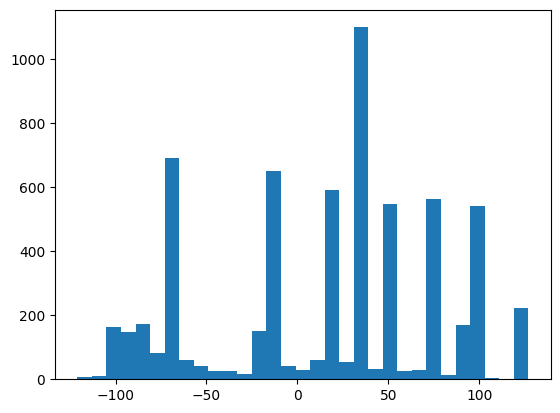

In [183]:
def signed_dec2hex_matrix(input):
    '''Convert a matrix which data is signed decimal to 8 bits hex with 2's complement'''
    temp = []
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(8)] ) )
    for i in input:
        test =bin8(i)
        test = int(test,base=2)
        hex_test = hex(test)[2:].zfill(2)
        temp.append(hex_test)

    return temp

def signed_dec2hex(input):
    '''Convert a number which data is signed decimal to 8 bits hex with 2's complement'''
    bin8 = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(8)] ) )
    test =bin8(input)
    test = int(test,base=2)
    hex_test = hex(test)[2:].zfill(2)

    return hex_test


def golden_gen(golden_layer_decimal):
    '''Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make it 4 element in a line, example of use : golden_gen(q_output_activation["Conv.3"]) '''
    golden = []
    i=0
    golden_in_numpy = golden_layer_decimal.cpu().numpy()
    test = golden_in_numpy.flatten()
    test =test.astype('int32')
    golden.append([])
    for j, data in enumerate(test):
        if(j%4==0 ):
            golden.append([])
            i = i+1
            golden[i].append(signed_dec2hex(data))
        if(j%4!=0):
            golden[i].append(signed_dec2hex(data))
    golden.pop(0)
    for indice,data in enumerate(golden):
        print(*data,sep='')

def input_or_weight_gen(layer_decimal):
    '''Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make each byte display in different place, example of use : input_or_weight_gen(quantized_model.Conv[1].weights)'''
    byte0 = []
    byte1 = []
    byte2 = []
    byte3 = []

    data_in_numpy = layer_decimal.cpu().numpy()
    data_test = data_in_numpy.flatten()
    data_test = data_test.astype('int32')
    data_test = signed_dec2hex_matrix(data_test)
    for indice,data in enumerate(data_test):
        if(indice%4 == 0):
            byte0.append(data)
        elif(indice%4 == 1):
            byte1.append(data)
        elif(indice%4 == 2):
            byte2.append(data)
        else:
            byte3.append(data)
    print("byte0:",*byte0)
    print("=======")
    print("byte1:",*byte1)
    print("=======")
    print("byte2:",*byte2)
    print("=======")
    print("byte3:",*byte3)
    print("=======")
    return byte0,byte1,byte2,byte3

def DecToBin_machine(num,accuracy):
    integer = int(num)
    flo = num - integer
    integercom = '{:1b}'.format(integer)
    tem = flo
    flo_list = []
    for i in range(accuracy):
        tem *= 2
        flo_list += str(int(tem))
        tem -= int(tem)
    flocom = flo_list
    binary_value =  ''.join(flocom)
    return binary_value

def customize_dw_input_gen(layer_decimal):
    '''Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make each byte display in different place, example of use : input_or_weight_gen(quantized_model.Conv[1].weights)'''
    batch,channel,rows, cols = layer_decimal.shape
    patches = []
    for d in range(channel):
        for i in range(0, rows, 3):
            for j in range(0, cols, 3):
                patch = layer_decimal[0,d,i:i+3, j:j+3]
                patches.append(patch)
    temp_data_in_np = []
    for i , data in enumerate(patches):
        data =data.cpu()
        temp = np.array(data)
        temp_data_in_np.append(temp)
    temp_np = np.array(temp_data_in_np)
    temp_np = temp_np.flatten()

    byte0 = []
    byte1 = []
    byte2 = []
    byte3 = []

    # data_in_numpy = layer_decimal.cpu().numpy()
    # data_test = data_in_numpy.flatten()
    data_test =temp_np.astype('int32')
    data_test = signed_dec2hex_matrix(data_test)
    for indice,data in enumerate(data_test):
        if(indice%3 == 0):
            byte0.append(data)
            byte3.append('00')
        elif(indice%3 == 1):
            byte1.append(data)
        elif(indice%3 == 2):
            byte2.append(data)
        # else:
        #     byte3.append(data)
    print("byte0:",*byte0)
    print("=======")
    print("byte1:",*byte1)
    print("=======")
    print("byte2:",*byte2)
    print("=======")
    print("byte3:",*byte3)
    print("=======")
    return byte0,byte1,byte2,byte3

def input_gen_with_0x_pw_ifmap(golden_layer_decimal):
    '''Only for pw ifmap, because HW request pw ifmap need to begin from channel,then W, finally H.Convert a layer output which is signed decimal in GPU to 8 bits hex with 2's complement in CPU and
     make it 4 element in a line, example of use : golden_gen(q_output_activation["Conv.3"]) '''
    golden_layer_decimal = golden_layer_decimal.permute(0,2,3,1)
    golden = []
    i=0
    golden_in_numpy = golden_layer_decimal.cpu().numpy()
    test = golden_in_numpy.flatten()
    test =test.astype('int32')
    golden.append([])
    for j, data in enumerate(test):
        if(j%4==0 ):
            golden.append([])
            i = i+1
            golden[i].append(signed_dec2hex(data))
        if(j%4!=0):
            golden[i].append(signed_dec2hex(data))
    golden.pop(0)
    temp = '0x'
    temp1 = ',\\'
    for indice,data in enumerate(golden):
        golden[indice].insert(0,temp)
        golden[indice].append(temp1)

    for indice,data in enumerate(golden):
        print(*data,sep='')
    return golden
#golden_gen(q_output_activation["Conv.3"])
# torch.save(quantized_model,"dw_customize_Toymodel.pt")
# print(signed_dec2hex(quantized_model.Conv[1].input_zero_point))
# input_or_weight_gen(q_input_activation["Conv.1"])
# print("===")
# input_or_weight_gen(quantized_model.Conv[4].weights)

# print(quantized_model.Conv[4].input_zero_point)

# DeS = quantized_model.Conv[3].store_scale
# print(DeS)
# #print(DeS *8192) # 2**13
# #print("deq_scale (shift 13):",DecToBin_machine(quantized_model.Conv[1].,8))
# print("req_scale (shift 6):",)
# print("output zero",)
# #binary_value = integercom + '.' + ''.join(flocom)
# result = DecToBin_machine(DeS,8)
# print(result)
# # 0.1100111101011100
#print(q_output_activation["Conv.2"])
#pw_input0, pw_input1, pw_input2, pw_input3 = input_or_weight_gen(q_input_activation["Conv.3"] - quantized_model.Conv[3].input_zero_point)
#pw_weight0, pw_weight, pw_weight2, pw_weight3 = input_or_weight_gen(quantized_model.Conv[2].weights - quantized_model.Conv[2].weight_zero_point)
#golden = golden_gen(q_output_activation["Conv.2"])
#print(quantized_model.Conv[2].ReQ_scale *256)
#test=quantized_model.Conv[2].ReQ_scale *256
#print(DecToBin_machine(test ,8))
#print(q_input_activation["Conv.3"].shape)
#print((input_activation["Conv.2"] - quantized_model.Conv[2].input_zero_point).round().clamp(-(2**(8-1)), 2**(8-1)-1))
#print(quantized_model.Conv[2].weights - quantized_model.Conv[2].weight_zero_point)
#q_input_activation_pw = q_input_activation["Conv.2"] .permute(0,2,3,1)
#pw_input0, pw_input1, pw_input2, pw_input3 = input_or_weight_gen(q_input_activation_pw)
#print(q_input_activation["Conv.2"])
#print(quantized_model.Conv[2].weights)
#pw_input0, pw_input1, pw_input2, pw_input3 = input_or_weight_gen(q_input_activation_pw- quantized_model.Conv[2].input_zero_point)

#######################################################################################################
import sys
np.set_printoptions(threshold=sys.maxsize)
#input_gen_with_0x_pw_ifmap(q_input_activation["Conv.2"])
#input_or_weight_gen(quantized_model.Conv[2].weights)
#output = torch.nn.functional.conv2d(input = q_input_activation["Conv.2"] , weight = quantized_model.Conv[2].weights , stride=1,padding=0,groups=1)
#print(output)
#print(q_input_activation["Conv.2"].numpy())
output = torch.nn.functional.conv2d(input = q_input_activation["Conv.2"]  , weight = quantized_model.Conv[2].weights, stride=1,padding=0,groups=1)
# print(output.numpy())
# print(output.int().numpy())
print(quantized_model.Conv[2].ReQ_scale *256)
test = DecToBin_machine(quantized_model.Conv[2].ReQ_scale*256,8)

output = quantized_model.Conv[2].ReQ_scale * output
#print(output.numpy())
#output += quantized_model.Conv[2].output_zero_point

#clamp and round
output = output.round().clamp(-(2**(8-1)), 2**(8-1)-1)
#print(quantized_model.Conv[2].output_zero_point)
#print(output.numpy())
#golden = golden_gen(output)

#######################################################################################################
y = torch.flatten(output)
y = y.cpu()
y = torch.flatten(y)
y = y.detach()
y = y.numpy()
print(y.shape)

plt.hist(y, bins='auto',density=False)
#print(q_input_activation["Conv.2"])

#print(q_output_activation["Conv.2"])


In [57]:
# p2d = (1,1,1,1)
# test = golden_layer_decimal = torch.nn.functional.pad(q_input_activation["Conv.4"],p2d,"constant",0)
# customize_dw_input_gen(test)
# input_or_weight_gen(quantized_model.Conv[4].weights)
# golden_gen(q_output_activation["Conv.2"])

43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
43434343
4343433e
41434338
430a4343
43434343
43434343
43434343
43414043
19c23243
43434343
438c4343
43434343
43434343
43434343
43414343
bc819a43
43434321
b4a04343
43434343
43434343
43434343
433c43f1
808b8284
82838182
83814343
43434343
43434343
43434343
40433281
80808384
83838482
82814343
43434343
43434143
4041433e
43439394
a0818382
82838381
82833243
43434343
41434343
43433e43
43ba81b9
b3828280
82848481
8384fb43
43434343
4343403c
41434343
ad819a9b
9a838181
82838381
83848c43
43434040
41404343
43431b9d
8fab988f
81828182
82828381
8

# Evaluate

In [58]:
test_loop(test_loader, FP32_model, loss_fn)

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.000034 



In [59]:
test_loop(test_loader, quantized_model, loss_fn)

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.000000 



In [60]:
print(output_activation.keys())
print(q_output_activation.keys())

dict_keys(['Conv.0', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5', 'Conv.6.avg_pool', 'Conv.6.fc.0', 'Conv.6.fc.1', 'Conv.6.fc.2', 'Conv.6.fc.3', 'Conv.7', 'Conv.8', 'backbone.0', 'backbone.1', 'backbone.2', 'backbone.3', 'backbone.4'])
dict_keys(['Conv.0', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4.avg_pool', 'Conv.4.fc.0', 'Conv.4.fc.1', 'Conv.4', 'Conv.5', 'backbone.0', 'backbone.1', 'backbone.2'])


(200704,)


(array([7.5951e+04, 8.3700e+03, 6.6440e+03, 7.1500e+03, 4.7330e+03,
        2.4850e+03, 1.2930e+03, 9.4700e+02, 9.7200e+02, 9.5900e+02,
        1.0030e+03, 1.0340e+03, 9.3900e+02, 9.6800e+02, 1.0750e+03,
        1.3371e+04, 6.6700e+02, 6.2700e+02, 6.4900e+02, 6.2500e+02,
        5.8000e+02, 6.4100e+02, 4.8200e+02, 4.9900e+02, 6.2600e+02,
        1.3242e+04, 3.7400e+02, 3.7200e+02, 4.7300e+02, 1.3223e+04,
        1.2961e+04, 1.3600e+02, 1.5100e+02, 1.3800e+02, 1.7600e+02,
        2.3200e+02, 1.2867e+04, 6.5000e+01, 1.2300e+02, 1.2881e+04]),
 array([0.        , 0.03509332, 0.07018664, 0.10527997, 0.14037329,
        0.17546661, 0.21055993, 0.24565326, 0.28074658, 0.31583989,
        0.35093322, 0.38602656, 0.42111987, 0.45621318, 0.49130651,
        0.52639985, 0.56149316, 0.59658647, 0.63167977, 0.66677314,
        0.70186645, 0.73695976, 0.77205312, 0.80714643, 0.84223974,
        0.87733305, 0.91242635, 0.94751972, 0.98261303, 1.01770639,
        1.0527997 , 1.08789301, 1.12298632, 1.

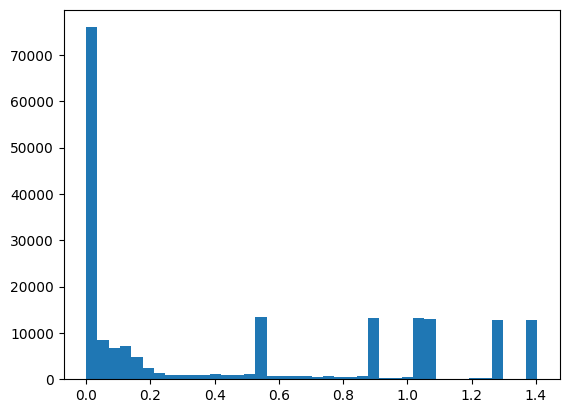

In [66]:
#y = torch.flatten(FP32_model.Conv[0].weight)
y = torch.flatten(output_activation['Conv.2'])
y = y.cpu()
y = torch.flatten(y)
y = y.detach()
y = y.numpy()
print(y.shape)

plt.hist(y, bins='auto',density=False)

(6272,)


(array([2587.,  176.,   74.,   46.,   34.,  556.,   20.,   18.,  562.,
          18., 1084.,   11.,  546.,  540.]),
 array([-128.        , -109.85713959,  -91.7142868 ,  -73.57142639,
         -55.42856979,  -37.2857132 ,  -19.1428566 ,   -1.        ,
          17.1428566 ,   35.2857132 ,   53.42856979,   71.57142639,
          89.7142868 ,  107.85713959,  126.        ]),
 <BarContainer object of 14 artists>)

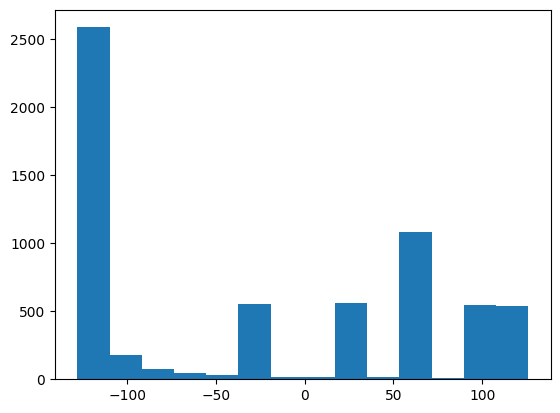

In [65]:
#x = torch.flatten(quantized_weights12)
#x = torch.flatten(quantized_model.Conv[1].weights)
#print(q_output_activation['Conv.3'])
x = torch.flatten(q_output_activation['Conv.2'])
x = x.cpu()
x = torch.flatten(x)
x = x.detach()
x = x.numpy()
print(x.shape)

plt.hist(x, bins='auto',density=False)

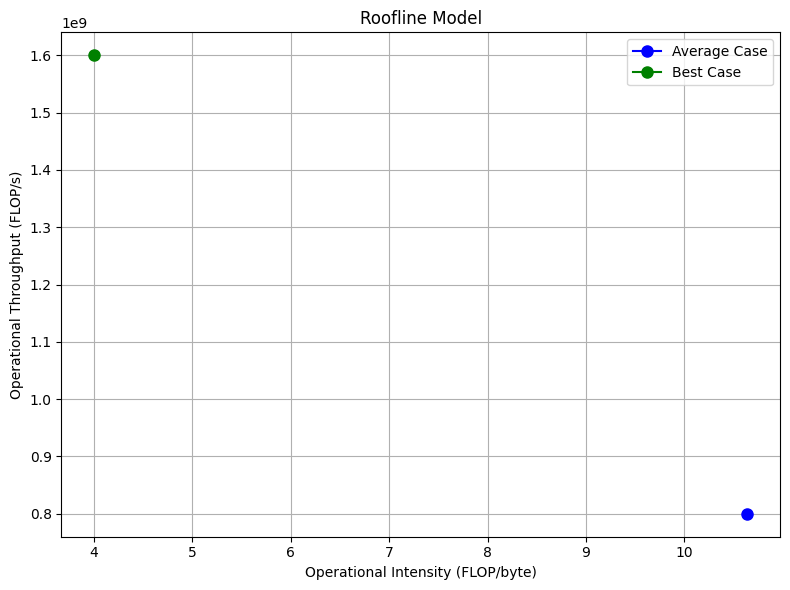

In [1]:
import matplotlib.pyplot as plt

# Operational Intensities (FLOP/byte) and Throughputs (FLOP/s)
# Replace these values with your calculated values
oi_avg = 10.64  # Operational intensity for average case (FLOP/byte)
oi_best = 4.0   # Operational intensity for best case (FLOP/byte)

throughput_avg = 800e6  # Throughput for average case (FLOP/s)
throughput_best = 1600e6  # Throughput for best case (FLOP/s)

# Plotting the roofline model
plt.figure(figsize=(8, 6))

# Plot the points for average and best case
plt.plot([oi_avg], [throughput_avg], marker='o', markersize=8, color='blue', label='Average Case')
plt.plot([oi_best], [throughput_best], marker='o', markersize=8, color='green', label='Best Case')

# Add labels and title
plt.xlabel('Operational Intensity (FLOP/byte)')
plt.ylabel('Operational Throughput (FLOP/s)')
plt.title('Roofline Model')

# Add a legend
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()